# Advanced Example: Testing the Stylized Facts of the Generative Model
We've already seen that the observed and simulated excess growth rate distributions are heavy-tailed. In this advanced example, we'll explore whether the daily excess growth rate trajectories computed using the Markov model exhibit two other important statistical properties (stylized facts):

* __Fact I: Absence of autocorrelations__: The autocorrelations of asset returns are often near-zero, except for very small intraday timescales (on order minutes or less) for which microstructure effects come into play. Given that we are using daily data, we expect the observed and simulated autocorrelations to be near zero. The lack of autocorrelation is consistent with the [random walk hypothesis](https://en.wikipedia.org/wiki/Random_walk_hypothesis).
* __Fact II: Volatility clustering__: Different volatility functions display a positive autocorrelation over several time periods, suggesting that high-volatility events tend to cluster in time. In this case, we'll explore the absolute value of the excess growth rate computed using daily data.
  
### Learning objectives
* __Prerequisites__: We begin by loading the daily growth rate Markov model file we saved in the worked example. Using this data, we'll set various variables and constants that are used later.
* __Task 1__: Compute the encoded and decoded out-of-sample model predictions. Starting from the stationary distribution $\bar\pi$, generate a population of encoded `SPY` growth rate discrete states and then decode these values back to growth rates.
* __Task 2__: Compute the stylized facts for the out-of-sample observed and simulated growth rate dataset.
    * `TODO`: Autocorrelation of the out-of-sample dataset
    * `TODO`: Volatility clustering of the out-of-sample dataset

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our lab problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl");

## Prerequisites: Load daily HMM model file
Let's begin by loading the [HDF5 encoded saved file](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) generated in the worked example using [a `load(...)`  method exported by the JLD2.jl package](https://github.com/JuliaIO/JLD2.jl). First, we specify the path to the saved file in the `path_to_save_file::String` variable:

In [5]:
ticker = "SPY"
path_to_save_file = joinpath(_PATH_TO_DATA,"HMM-$(ticker)-daily-aggregate.jld2");

then we [call the `load(...)` method exported by the JLD2.jl package](https://github.com/JuliaIO/JLD2.jl), which reads the binary saved file and returns the saved data as a dictionary; we assign the data to the `saved_state_dict::Dict{String, Any}` variable:

In [7]:
saved_state_dict = load(path_to_save_file)

Dict{String, Any} with 5 entries:
  "insampledataset"    => [1.51294, 1.10337, 0.783659, 0.74692, -0.651317, 1.28…
  "stationary"         => Categorical{Float64, Vector{Float64}}(…
  "model"              => MyHiddenMarkovModel([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  ……
  "decode"             => Dict{Int64, Normal}(5=>Normal{Float64}(μ=-3.5653, σ=0…
  "outofsampledataset" => [3.06408, -3.55485, -3.04269, -5.37542, -1.35013, -1.…

The `saved_state_dict::Dict{String, Any}` dictionary holds the out-of-sample dataset (`SPY` growth rate data, not used for training) in the `outofsampledataset` key. We retrieve the out-of-sample data and store it in the `out_of_sample_dataset::Array{Float64,1}` variable. The length of the `out_of_sample_dataset::Array{Float64,1}` array is the number of test examples we have:

In [9]:
out_of_sample_dataset = saved_state_dict["outofsampledataset"]

467-element Vector{Float64}:
  3.064075246029285
 -3.554849634227477
 -3.0426929891956753
 -5.375424627605836
 -1.3501276473577843
 -1.5605940652938788
 -4.806425661497439
  6.26107604235329
  0.44382036758096866
  3.1480968799843168
 -6.152874401787635
 -3.678107580537128
 -2.185498251756967
  ⋮
 -0.46407701702660653
 -0.13948780347442888
  0.9060279176165984
  1.5886628608286195
  0.6856283645585958
 -2.393298385192234
  0.9267625992892551
  2.0955659969498117
 -0.15429197151137425
 -1.6983801647597287
  2.1267483471553437
  0.5638387917487099

Next, we get [the `MyHiddenMarkovModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/markov/#VLQuantitativeFinancePackage.MyHiddenMarkovModel) that we constructed in the worked example from the `saved_state_dict::Dict{String, Any}` dictionary using the `model::String` key. We save the Markov model in the `model::MyHiddenMarkovModel` variable:

In [11]:
model = saved_state_dict["model"];

## Task 1: Compute the decoded out-of-sample model prediction
In this task, you will sample the `model::MyHiddenMarkovModel` instance and will generate a family of encoded state sequences, i.e., a series of discrete state values $s_{j}\in\mathcal{S}$ where each sample trajectory starts from a draw from the stationary distribution $\bar\pi$. 
* We computed the stationary distribution $\bar\pi$ in the worked example; here we access the saved value from the `saved_state_dict::Dict{String, Any}` dictionary using the `stationary::String` key. We save the stationary distribution in the `π̄::Categorical{Float64, Vector{Float64}}` variable:

In [13]:
π̄ = saved_state_dict["stationary"];

Let's now generate the `encoded_archive::Array{Int64,2}` array, which holds `number_of_paths` discrete state trajectories each of length `number_of_steps` by using some fantastic syntactic-sugar in Julia:
* Internally, we've created a function `(m::MyHiddenMarkovModel)(start::Int64, steps::Int64) = _simulate(m, start, steps)` which provides a short-cut syntax to sampling the `model::MyHiddenMarkovModel` instance, where the sampling logic is encoded in the private `_simulate(m, start, steps)` function.

After declaring how many sample paths we want (specified in the `number_of_paths::Int64` variable), how many steps we are going to take (specified in the `number_of_steps::Int64` variable), and initializing the `encoded_archive::Array{Int64,2}` array which will store the model samples, we populate the sample array using a nested [`for-loop`](https://docs.julialang.org/en/v1/manual/variables-and-scoping/#Loops-and-Comprehensions):
* The outer loop iterates over the sample paths, the `i` index, where we generate an initial state for each sample path by drawing a sample from the $\bar\pi$ distribution. We save the initial state in the `start_state::Int64` variable.
* The inner loop iterates over the time steps in each sample path, the `j` index, where we generate a `number_of_steps`$\times$ `1` array of discrete state values $s\in\mathcal{S}$ in the `tmp::Array{Int64,1}` array. We then add the values of the `tmp` array to the `encoded_archive` array, where the time steps are on the rows and the sample paths are on the columns.

In [15]:
number_of_paths = 10000;
number_of_steps = length(out_of_sample_dataset); # average number of trading days per year
encoded_archive = Array{Int64,2}(undef, number_of_steps, number_of_paths);
for i ∈ 1:number_of_paths
    start_state = rand(π̄);
    tmp = model(start_state, number_of_steps) # generates state sequence of length number_of_steps
    for j ∈ 1:number_of_steps
        encoded_archive[j,i] = tmp[j]
    end
end
encoded_archive

467×10000 Matrix{Int64}:
 16  31  48  80  15  15  75   5  37  …  58  56  62  64   1  15   8  36  68
 54  63  13  80  13  70  21  73  48     58  48  44  28  74  65  28  38  59
 69  73  36  38   2  54  68  20  71     18  73   5  59  75  48   5  57  16
 32   3   5  34  19  52  68   4  16      8   3  54  73  68  59  73  33   9
 55   7   1  36  39  68  38  14  12      8   7  15  65  72  21  50  20  18
 59   8  12  78  49  68  21   3  27  …  19   5  72  77  37  42  13  12  59
 11   8  43  75  62  30  63   3  24     75  38  24   1  21  78  26  53  80
 78  57  41  71  37  44  38   1  13     48  72  58  28  42  75  54  30  36
 48  22  18  47   7  34  31  53  26     59   1  34  53  75  71  64  56   9
 68  45  29  48  68  65   8  30  19     11  37   4  58  48  58  48  64   2
 39  68  47  13  59  40   8  32  33  …  12  61   6  58  71   9  68  70  53
 69  39  53  33  33  63  13  55  67     69  25  33  21  71  59  59  68  32
 14  41  58  35  42  34   5  14  55     32  24  48  21   6  27  37  31  56


### TODO: Compute the decoded simulation array
Now that we have populated the `encoded_archive::Array{Int64,2}` array, which holds the hidden discrete states, we need to convert the discrete states back into floating point excess growth rate values. We do this using a _decoding model_ which transforms the encoded values into growth rate values. We generated (and persisted) the _decode model_ in the worked example. 
* Load the _decode model_ from the `saved_state_dict::Dict{String, Any}` dictionary using the `decode::String` key. We save the _decode model_ in the `decode_distribution_model::Dict{Int64, Normal}` dictionary.

In [17]:
decode_distribution_model = saved_state_dict["decode"];

The `decode_distribution_model::Dict{Int64, Normal}` dictionary holds a [Normal distribution model](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal) for each state $s\in\mathcal{S}$. We sample these distributions to generate a value of the excess growth rate that corresponds to a particular discrete state `s.` Thus, to decode the encoded sample array, we iterate through the `encoded_archive` array and sample the _decode model_ that is associated with $s\in\mathcal{S}$, and then save that value in the `out_of_sample_decoded_archive::Array{Float64,2}` array using a nested [`for-loop`](https://docs.julialang.org/en/v1/manual/variables-and-scoping/#Loops-and-Comprehensions):
* The outer loop iterates over the sample paths, the `i` index, while the inner loop, the `j` index, iterates over the time steps. Inside the inner loop, we select a state `s,` access the corresponding _Normal decode model_ for state `s,` (the `j,i` element of the `encoded_archive`) and sample that model [using a `rand(...)` method exported by the  Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Base.rand-Tuple{AbstractRNG,%20UnivariateDistribution}) in combination with the [Julia pipe `|>` operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping).

The `out_of_sample_decoded_archive::Array{Float64,2}` holds values for the excess growth rate for each time step and sample path.

In [19]:
out_of_sample_decoded_archive = Array{Float64,2}(undef, number_of_steps, number_of_paths);
for i ∈ 1:number_of_paths
    for j ∈ 1:number_of_steps
        s = encoded_archive[j,i];
        out_of_sample_decoded_archive[j,i] =  decode_distribution_model[s] |> d -> rand(d)
    end
end
out_of_sample_decoded_archive # actual excess growth value (not internal state variables)

467×10000 Matrix{Float64}:
 -1.45808    -0.276966    0.543082   …  -2.75816    -0.00704063   2.22392
  0.867384    1.59287    -1.79531       -0.465995    0.0725205    1.24558
  2.35444     2.9514     -0.0114813     -3.29683     1.09183     -1.46463
 -0.225816   -4.77991    -3.41103        3.10827    -0.148766    -2.4214
  0.985891   -2.87415   -13.5823         0.631368   -1.08309     -1.24286
  1.28048    -2.76698    -2.00717    …  -1.7596     -2.04767      1.23221
 -2.08634    -2.75138     0.2946        -0.617772    0.801814    11.5563
  5.0368      1.07546     0.210774       0.879319   -0.34624     -0.0387126
  0.544247   -0.889665   -1.26819        1.6745      1.0581      -2.51397
  2.2172      0.384606   -0.400865       0.50739     1.71509     -5.43328
  0.0840853   2.19296     0.506129   …   2.19476     2.41358      0.830384
  2.24304     0.107927    0.825051       1.26572     2.21143     -0.214898
 -1.67173     0.187004    1.16283        0.0324966  -0.290458     1.03562
  ⋮      

## Task 2: Stylized facts for out-of-sample dataset
This task compares the stylized facts for the observed out-of-sample and simulated excess growth datasets. In particular, we'll look at two stylized facts, namely, the autocorrelation of the excess growth rate and the volatility clustering, i.e., the autocorrelation of the absolute value of the excess growth rate.

### TODO: Autocorrelation of the out-of-sample dataset
Let's look at the [autocorrelation as a function of the time lag](https://en.wikipedia.org/wiki/Autocorrelation) for the data in the `out_of_sample_dataset` and a randomly selected trajectory from the `out_of_sample_decoded_archive` array. 

#### Summary
`Unhide` the code block below to see how we computed and plotted the [autocorrelation function](https://en.wikipedia.org/wiki/Autocorrelation) for the simulated and observed out-of-sample dataset.
* The [random walk hypothesis](https://en.wikipedia.org/wiki/Random_walk_hypothesis) suggests that for lags greater than `1`, the autocorrelation of the return should be zero. We tested this idea using the observed out-of-sample growth rates in the `out_of_sample_dataset::Array{Float64,1}` array and the simulated growth rates in the `out_of_sample_decoded_archive` array.
* The observed (orange) and simulated (blue) excess growth rates show a near-zero autocorrelation at a 99% confidence level as a function of the lag (day), with the exception of a few lags in the first hundred days.
* Although both the data and the model show a few violations of the autocorrelation hypothesis, these violations are weak.

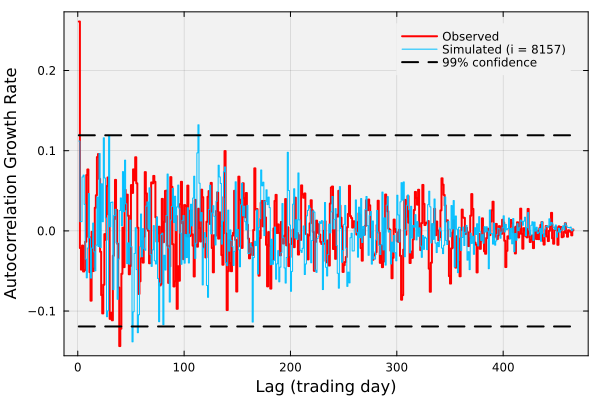

In [36]:
let

    # generate a random index -
    random_index = rand(1:number_of_paths);
    
    plot(autocor(out_of_sample_dataset, (1:(number_of_steps - 1) |> collect)), label="Observed", lw=2, c=:red, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, linetype=:steppost)
    plot!(autocor(out_of_sample_decoded_archive[:,random_index], (1:(number_of_steps - 1) |> collect)), c=:deepskyblue1, 
        label="Simulated (i = $(random_index))", linetype=:steppost)
    
    LINE = (2.576/sqrt(number_of_steps))*ones(number_of_steps-1);
    plot!(LINE, label="99% confidence", lw=2, c=:black, ls=:dash)
    plot!(-LINE, label="", lw=2, c=:black, ls=:dash)
    xlabel!("Lag (trading day)", fontsize=18)
    ylabel!("Autocorrelation Growth Rate", fontsize=18)

    # uncomment me to save to file -
    # savefig(joinpath(_PATH_TO_FIGS, "Fig-Autocorrelation-HMM-GenModel-$(ticker).pdf"));
end

### TODO: Volatility clustering of the out-of-sample dataset
Next, let's consider volatility clustering. Volatility clustering is determined by examining the autocorrelation of the absolute values of the excess growth rate for different lag values. In actual data, we expect a positive absolute autocorrelation for short lags. Volatility clustering indicates that periods of high volatility, such as significant changes in returns, tend to occur close together in time.

### Summary
`Unhide` the code block below to see how we computed and plotted the [autocorrelation function](https://en.wikipedia.org/wiki/Autocorrelation) for the absolute values of the simulated and observed out-of-sample excess growth rates.
* The observed out-of-sample dataset (orange line) shows a positive autocorrelation for lags less than approximately `10 days` at a 99% confidence level. This suggests the market has a memory of approximately 10 days or less following large disruptions.
* The excess growth rate trajectories produced by the Markov model (blue line) don't show volatility clustering; thus, this model (at least as it's currently implemented) will not capture the clustering of high-volatility events.

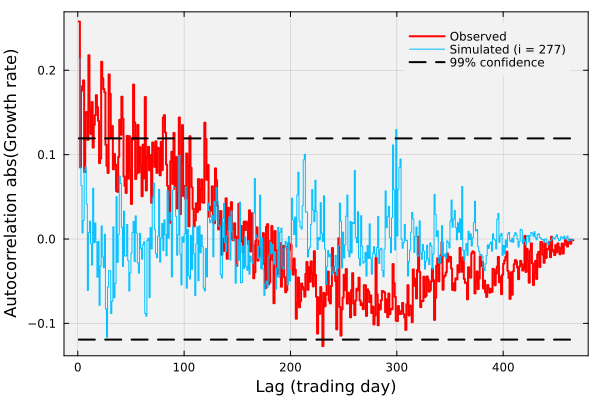

In [38]:
let

    # generate a random index -
    random_index = rand(1:number_of_paths);
    
    plot(autocor(abs.(out_of_sample_dataset), (1:(number_of_steps - 1) |> collect)), label="Observed", lw=2, c=:red,  
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, linetype=:steppost)
    plot!(autocor(abs.(out_of_sample_decoded_archive[:,random_index]), (1:(number_of_steps - 1) |> collect)), c=:deepskyblue1, 
        label="Simulated (i = $(random_index))", linetype=:steppost)
    
    LINE = (2.576/sqrt(number_of_steps))*ones(number_of_steps-1);
    plot!(LINE, label="99% confidence", lw=2, c=:black, ls=:dash)
    plot!(-LINE, label="", lw=2, c=:black, ls=:dash)
    xlabel!("Lag (trading day)", fontsize=18)
    ylabel!("Autocorrelation abs(Growth rate)", fontsize=18)

    # uncomment me to save to file -
    # savefig(joinpath(_PATH_TO_FIGS, "Fig-VolClustering-HMM-GenModel-$(ticker).pdf"));
end

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. You should decide solely based on your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.